<a href="https://colab.research.google.com/github/HanaeELMEKKI/COMP-6321-Assignment-2/blob/main/Question%202/Assignement2_Implementation_Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation Question 2**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.utils.data as data
import numpy as np

**Preparation of the dataset**

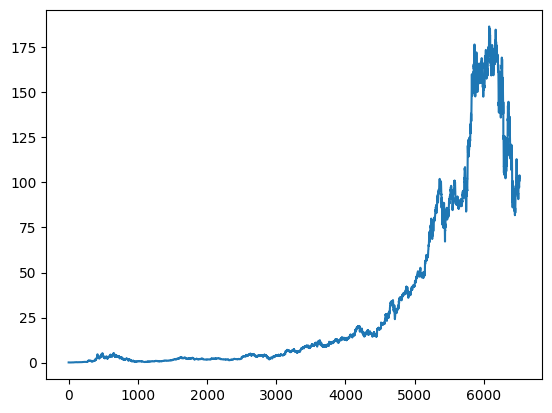

In [ ]:
#read cvs file into dataframe
df = pd.read_csv("https://raw.githubusercontent.com/HanaeELMEKKI/COMP-6321-Assignment-2/main/Question%202/AMZN.csv")
close_column = df[["Close"]]
timeseries = close_column.values.astype('float32')

plt.plot(timeseries)
plt.show()

def create_dataset(dataset, window_size):
    sequences, targets = [], []
    for i in range(len(dataset)-window_size):
        feature = dataset[i:i+window_size]
        target = dataset[i+1:i+window_size+1]
        sequences.append(feature)
        targets.append(target)
    return torch.tensor(sequences), torch.tensor(targets)

**Pre-processing of the dataset**

In [ ]:
sequence_window_size = 10
sequences, targets = create_dataset(timeseries, sequence_window_size)
scaler = MinMaxScaler()

reshaped_sequences = scaler.fit_transform(sequences.reshape(-1, sequences.shape[-1]))
reshaped_targets = scaler.transform(targets.reshape(-1, targets.shape[-1]))

tensor_sequences = torch.tensor(reshaped_sequences, dtype=torch.float32)
tensor_targets = torch.tensor(reshaped_targets, dtype=torch.float32)

<ipython-input-2-96fde0e81a7b>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(sequences), torch.tensor(targets)


**Train Vanilla LSTM**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [ ]:
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
loader = data.DataLoader(data.TensorDataset(tensor_sequences, tensor_targets), batch_size=8)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    for inputs, targets in loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
      print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [0/100], Loss: 0.0002
Epoch [1/100], Loss: 0.00017063526320271194
Epoch [2/100], Loss: 0.00010998601646861061
Epoch [3/100], Loss: 0.00013828210649080575
Epoch [4/100], Loss: 0.000120911980047822
Epoch [5/100], Loss: 9.639439667807892e-05
Epoch [6/100], Loss: 6.221511284820735e-05
Epoch [7/100], Loss: 5.458586019813083e-05
Epoch [8/100], Loss: 5.355630855774507e-05
Epoch [9/100], Loss: 4.8956237151287496e-05
Epoch [10/100], Loss: 4.5761389628751203e-05
Epoch [10/100], Loss: 0.0000
Epoch [11/100], Loss: 4.385744614410214e-05
Epoch [12/100], Loss: 5.554958988795988e-05
Epoch [13/100], Loss: 5.238350058789365e-05
Epoch [14/100], Loss: 9.116683941101655e-05
Epoch [15/100], Loss: 9.962548938347027e-05
Epoch [16/100], Loss: 0.0001324741169810295
Epoch [17/100], Loss: 0.0001287728809984401
Epoch [18/100], Loss: 0.0002478338428772986
Epoch [19/100], Loss: 0.00024662583018653095
Epoch [20/100], Loss: 0.0004514583561103791
Epoch [20/100], Loss: 0.0004
Epoch [21/100], Loss: 0.00042258235043

**Comparison**

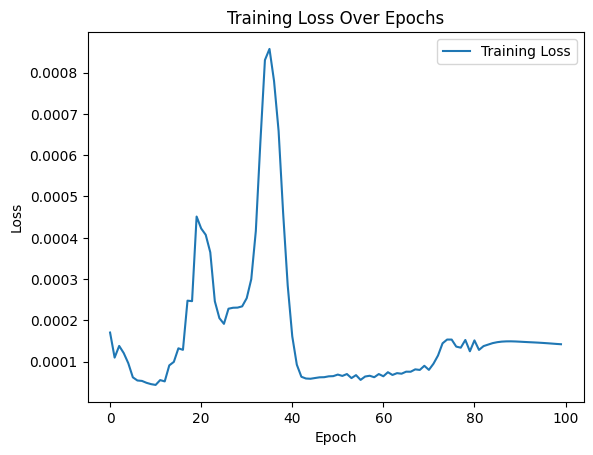

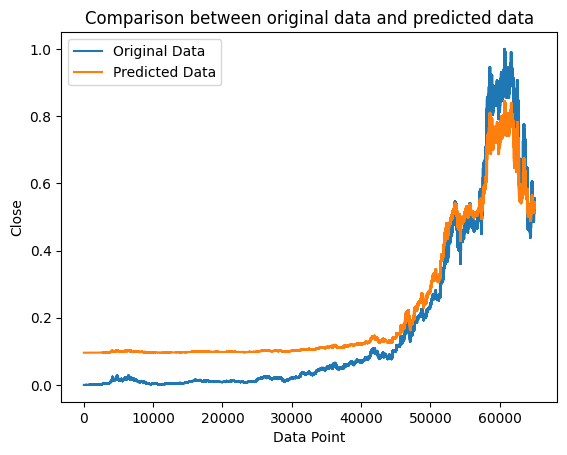

In [ ]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
predictions = []

model.eval()
with torch.no_grad():
  test_loader = data.DataLoader(data.TensorDataset(tensor_sequences, tensor_targets), batch_size=1)
  for inputs, targets in test_loader:
          outputs = model(inputs)
          predictions.append(outputs.detach().numpy())

plt.plot(tensor_targets, label='Original Data')
plt.plot(np.squeeze(predictions), label='Predicted Data')
plt.xlabel('Data Point')
plt.ylabel('Close')
plt.title('Comparison between original data and predicted data')
plt.legend()
plt.show()
